In [1]:
import numpy as np
np.__version__


'1.23.5'

In [2]:
import tpot
print('tpot %s' % tpot.__version__)

#importing the libraries and the Titanic dataset
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

#df initially ingests the Titanic data
df = pd.read_csv('train.csv') #read the Titanic data
df_test = pd.read_csv('test.csv') #read the Titanic data
df_train = df.drop(['Survived'], axis=1)
df_target = df['Survived']

tpot 0.11.7


In [3]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

def preprocessor (df_proc: pd.DataFrame) -> pd.DataFrame:
    df_proc['Fare'] = df_proc.Fare.fillna((df_proc.Fare.median())) #filling in Fare field with the median
    
    # Adding a column Family_Size
    df_proc['Family_Size'] = 0
    df_proc['Family_Size'] = df_proc['Parch']+df_proc['SibSp']
 
    # Adding a column Alone
    df_proc['Alone'] = 0
    df_proc.loc[df_proc.Family_Size == 0, 'Alone'] = 1
    
    avg_age_M = df_proc[df_proc.Sex =='male'].Age.mean()
    avg_age_F = df_proc[df_proc.Sex =='female'].Age.mean()
    no_age_list = df_proc.Age.isna() #build list of passengers that need their age fixed
    
    #Filling in the null values in Embarked and Age
    df_proc.Embarked = df_proc.Embarked.fillna((df_proc.Embarked.mode()[0])) #filling in Embarked field with the mode (S for the training set)
    df_proc.loc[(no_age_list & (df_proc.Sex=='male')), 'Age'] = avg_age_M #all men w/o age get the average age for men
    df_proc.loc[(no_age_list & (df_proc.Sex=='female')), 'Age'] = avg_age_F #all women w/o age get the average age for women
    
    #drop the columns that are no longer useful
        #PassengerId, Name, Ticket number, and Cabin have no bearing on survival
        #SibSp and Parch are integrated into Family Size and Alone

    df_proc.drop(['PassengerId', 'Name','SibSp','Parch','Ticket','Cabin'], axis=1, inplace=True)

    ss_scaler = StandardScaler()
    ohe = OneHotEncoder()

    # define column transformer and set n_jobs to use all cores
    col_transformer = ColumnTransformer(
                        transformers=[
                        ('ss', StandardScaler(), ['Pclass', 
                                                  'Age', 
                                                  'Fare',
                                                 'Family_Size',
                                                 'Alone']),
                        ('ohe', OneHotEncoder(), ['Embarked', 
                                                  'Sex'])
                    ],
                    remainder='passthrough',
                    verbose_feature_names_out = False,
                    n_jobs=-1
                    )

    transformed = col_transformer.fit_transform(df_proc)
    return pd.DataFrame(transformed, columns=col_transformer.get_feature_names_out())

In [4]:
from sklearn.model_selection import cross_val_score 
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import VotingClassifier


X = preprocessor(df_train.copy())
print(X.info())
print(df_train.info())

from sklearn.model_selection import train_test_split
#split prepared Titanic data between the test set (after the best model is chosen) 
#and the train set (which will be cross-validated) 
X_train, X_test, y_train, y_test = train_test_split(X, df_target, test_size=0.2, random_state=3)
print("Null prediction =" + str(1 - y_train.mean()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Pclass       891 non-null    float64
 1   Age          891 non-null    float64
 2   Fare         891 non-null    float64
 3   Family_Size  891 non-null    float64
 4   Alone        891 non-null    float64
 5   Embarked_C   891 non-null    float64
 6   Embarked_Q   891 non-null    float64
 7   Embarked_S   891 non-null    float64
 8   Sex_female   891 non-null    float64
 9   Sex_male     891 non-null    float64
dtypes: float64(10)
memory usage: 69.7 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Pclass       891 non-null    int64  
 2   Name         891 non-null    object 
 3   Sex          891 non-nul

>svm poly 0.796 (0.037)
>logreg 0.807 (0.036)
>knn5 0.802 (0.038)
>knn20 0.807 (0.042)
>gpc_rbf_isotropic 0.816 (0.035)
>gnb 0.787 (0.039)
>svm rbf 0.826 (0.037)
>svm3 0.826 (0.037)
>dtc 0.778 (0.044)
>rfc 0.813 (0.038)
>ada 0.809 (0.036)
>mlp 0.813 (0.034)
>xgb_default 0.809 (0.039)
>xgb_tuned 0.844 (0.039)
>hard_voting 0.832 (0.036)
>soft_voting 0.829 (0.041)


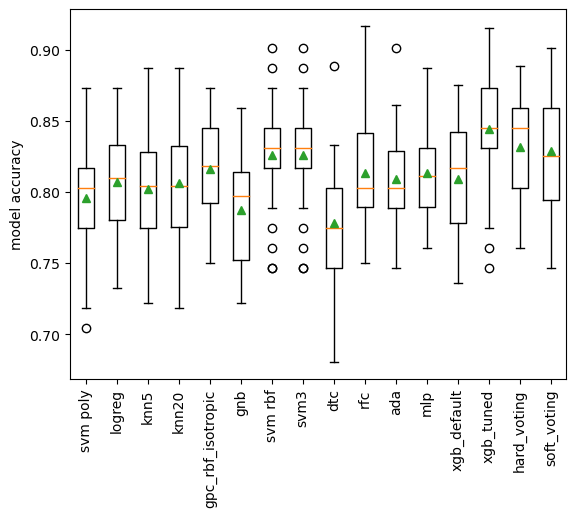

Wall time: 1min 33s


In [5]:
%%time
# compare soft voting ensemble to standalone classifiers
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from matplotlib import pyplot
 
# get a voting ensemble of models
def get_voting(vote):
    # define the base models
    models = list()
    #models.append(('svm poly', SVC(probability=True, kernel='poly', degree=1)))
    #models.append(('logreg', LogisticRegression(solver='liblinear')))
    #models.append(('knn5', KNeighborsClassifier(n_neighbors=5)))
    #models.append(('knn20', KNeighborsClassifier(n_neighbors=20)))
    kernel = 1.0 * RBF([1.0])
    models.append(('gpc_rbf_isotropic', GaussianProcessClassifier(kernel=kernel)))
    #models.append(('gnb', GaussianNB()))
    models.append(('svm2', SVC(probability=True, kernel = 'rbf', random_state = 0)))
    #models.append(('svm3', SVC(probability=True, kernel = 'rbf', random_state = 29)))
    #models.append(('dtc', DecisionTreeClassifier(random_state=0)))
    models.append(('rfc', RandomForestClassifier(n_estimators=100)))
    #models.append(('ada', AdaBoostClassifier()))
    #models.append(('mlp', MLPClassifier(alpha=1, max_iter=1000)))
    models.append(('xgb_tuned', XGBClassifier(eta= 0.1, gamma= 0, max_depth= 10, max_leaves= 0, min_child_weight= 7, scale_pos_weight= 1)))

    # define the voting ensemble
    ensemble = VotingClassifier(estimators=models, voting=vote)
    return ensemble
 
# get a list of models to evaluate
def get_models():
    models = dict()
    models['svm poly'] = SVC(probability=True, kernel='poly', degree=1)
    models['logreg'] = LogisticRegression(solver='liblinear')
    models['knn5'] = KNeighborsClassifier(n_neighbors=5)
    models['knn20'] = KNeighborsClassifier(n_neighbors=20)
    kernel = 1.0 * RBF([1.0])
    models['gpc_rbf_isotropic'] = GaussianProcessClassifier(kernel=kernel)
    models['gnb'] = GaussianNB()
    models['svm rbf'] = SVC(probability=True, kernel = 'rbf', random_state = 0)
    models['svm3'] = SVC(probability=True, kernel = 'rbf', random_state = 29)
    models['dtc'] = DecisionTreeClassifier(random_state=0)
    models['rfc'] = RandomForestClassifier(n_estimators=100)
    models['ada'] = AdaBoostClassifier()
    models['mlp'] = MLPClassifier(alpha=1, max_iter=1000)
    models['xgb_default'] = XGBClassifier()
    models['xgb_tuned'] = XGBClassifier(eta= 0.1, gamma= 0, max_depth= 10, max_leaves= 0, min_child_weight= 7, scale_pos_weight= 1)
    models['hard_voting'] = get_voting('hard')
    models['soft_voting'] = get_voting('soft')
    return models

# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return scores
 
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
 scores = evaluate_model(model, X_train, y_train)
 results.append(scores)
 names.append(name)
 print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
plt.ylabel('model accuracy')
plt.xticks(rotation=90)
pyplot.show()

In [6]:
from tpot import TPOTClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
tpot = TPOTClassifier(generations=5, population_size=50, cv=cv, scoring='accuracy', verbosity=2, random_state=1, n_jobs=-1)
tpot.fit(X_train, y_train)
print(tpot.score(X_test, y_test))
tpot.export('tpot_pipeline.py')

Optimization Progress:   0%|          | 0/300 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.8384911319770475

Generation 2 - Current best internal CV score: 0.8384911319770475

Generation 3 - Current best internal CV score: 0.8394170579029735

Generation 4 - Current best internal CV score: 0.8394170579029735

Generation 5 - Current best internal CV score: 0.8394170579029735

Best pipeline: XGBClassifier(XGBClassifier(input_matrix, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=100, n_jobs=1, subsample=0.9000000000000001, verbosity=0), learning_rate=0.001, max_depth=3, min_child_weight=1, n_estimators=100, n_jobs=1, subsample=0.9500000000000001, verbosity=0)
0.7932960893854749


In [7]:
%%time
from sklearn.model_selection import GridSearchCV

from skopt import BayesSearchCV

# Bayesian
n_iter = 70

param_grid = {
    "classifier__learning_rate": (0.0001, 0.1, "log-uniform"),
    "classifier__n_estimators": (100,  1000) ,
    "classifier__max_depth": (4, 400) 
}

#reg_bay = BayesSearchCV(estimator=pipe,
#                    search_spaces=param_grid,
#                    n_iter=n_iter,
#                    cv=5,
#                    n_jobs=8,
#                    scoring='roc_auc',
#                    random_state=123)

#model_bay = reg_bay.fit(X, y)


# grid search positive class weights with xgboost for imbalance classification
from numpy import mean
from sklearn.model_selection import RepeatedStratifiedKFold
from xgboost import XGBClassifier
# define model
model = XGBClassifier()
# define grid
#weights = [1, 2, 3, 10, 25, 50, 75, 99, 100, 1000]
weights = [1] #1
leaves = [0, 1] #0
child_weights = [6, 7, 8] #6,7
depths = [9, 10, 11] #9,10
gammas = [0, 1] #1,0
etas = [0.01, 0.1, 0.2] #0.1
param_grid = dict(scale_pos_weight=weights, 
                  max_leaves=leaves, 
                  min_child_weight=child_weights, 
                  max_depth=depths,
                  gamma=gammas,
                  eta=etas) #83651
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid search
bscv = BayesSearchCV(estimator=model, search_spaces=param_grid, n_jobs=-1, cv=cv, scoring='accuracy')
#grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='accuracy')

# execute the grid search
bscv_result = bscv.fit(X_train, y_train)
#grid_result = grid.fit(X, df_target)
# report the best configuration
print("Best: %f using %s" % (bscv_result.best_score_, bscv_result.best_params_))
#print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# report all configurations
means = bscv_result.cv_results_['mean_test_score']
stds = bscv_result.cv_results_['std_test_score']
params = bscv_result.cv_results_['params']
#means = grid_result.cv_results_['mean_test_score']
#stds = grid_result.cv_results_['std_test_score']
#params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

C:\Users\xAdmin\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\xAdmin\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\xAdmin\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\xAdmin\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\xAdmin\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\x

Best: 0.850652 using OrderedDict([('eta', 0.1), ('gamma', 0), ('max_depth', 11), ('max_leaves', 1), ('min_child_weight', 6), ('scale_pos_weight', 1)])
0.842227 (0.038481) with: OrderedDict([('eta', 0.2), ('gamma', 0), ('max_depth', 9), ('max_leaves', 1), ('min_child_weight', 7), ('scale_pos_weight', 1)])
0.846433 (0.039599) with: OrderedDict([('eta', 0.2), ('gamma', 1), ('max_depth', 11), ('max_leaves', 0), ('min_child_weight', 6), ('scale_pos_weight', 1)])
0.842227 (0.038481) with: OrderedDict([('eta', 0.2), ('gamma', 0), ('max_depth', 11), ('max_leaves', 0), ('min_child_weight', 7), ('scale_pos_weight', 1)])
0.843603 (0.043358) with: OrderedDict([('eta', 0.1), ('gamma', 1), ('max_depth', 11), ('max_leaves', 1), ('min_child_weight', 7), ('scale_pos_weight', 1)])
0.843610 (0.040298) with: OrderedDict([('eta', 0.2), ('gamma', 1), ('max_depth', 11), ('max_leaves', 1), ('min_child_weight', 7), ('scale_pos_weight', 1)])
0.809448 (0.037040) with: OrderedDict([('eta', 0.01), ('gamma', 0), ('

xgb_10 cross validation of training data: 0.8484154929577464
xgb_10 validation on test data: 0.8044692737430168



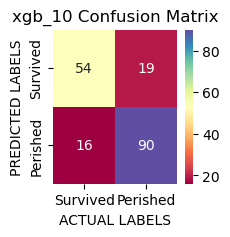

xgb_11 cross validation of training data: 0.8540297339593115
xgb_11 validation on test data: 0.8156424581005587



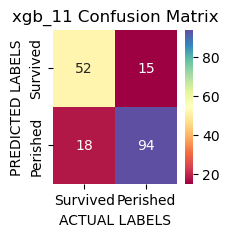

hard_ensemble cross validation of training data: 0.8540297339593114
hard_ensemble validation on test data: 0.8100558659217877



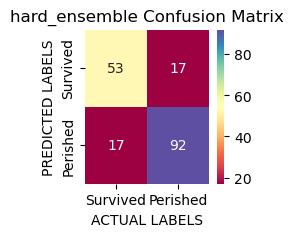

In [8]:
from sklearn.model_selection import cross_val_score 
from sklearn import metrics
from sklearn.metrics import confusion_matrix

xgb_10 = XGBClassifier(eta= 0.1, gamma= 0, max_depth= 10, max_leaves= 0, min_child_weight= 7, scale_pos_weight= 1)
xgb_11 = XGBClassifier(eta= 0.1, gamma= 0, max_depth= 11, max_leaves= 1, min_child_weight= 6, scale_pos_weight= 1)

xgb_10.fit(X_train, y_train)

print('xgb_10 cross validation of training data: ' + str(cross_val_score(xgb_10, X_train, y_train, cv=10, scoring='accuracy').mean()))
print('xgb_10 validation on test data: ' + str(metrics.accuracy_score(xgb_10.predict(X_test), y_test)) + '\n')
cm = confusion_matrix(y_test, xgb_10.predict(X_test))
tn, fp, fn, tp = confusion_matrix(y_test, xgb_10.predict(X_test)).ravel()
cm = [[tp,fp],[fn,tn]]

#Plot the matrix
fig, ax = plt.subplots(figsize=(2, 2))
sns.heatmap(cm, annot=True, fmt = "d", cmap="Spectral", ax=ax)

# labels, title and ticks
ax.set_xlabel('ACTUAL LABELS')
ax.set_ylabel('PREDICTED LABELS') 
ax.set_title('xgb_10 Confusion Matrix')
ax.xaxis.set_ticklabels(['Survived', 'Perished'])
ax.yaxis.set_ticklabels(['Survived', 'Perished'])
plt.show()

xgb_11.fit(X_train, y_train)

print('xgb_11 cross validation of training data: ' + str(cross_val_score(xgb_11, X_train, y_train, cv=10, scoring='accuracy').mean()))
print('xgb_11 validation on test data: ' + str(metrics.accuracy_score(xgb_11.predict(X_test), y_test)) + '\n')
cm = confusion_matrix(y_test, xgb_11.predict(X_test))
tn, fp, fn, tp = confusion_matrix(y_test, xgb_11.predict(X_test)).ravel()
cm = [[tp,fp],[fn,tn]]

#Plot the matrix
fig, ax = plt.subplots(figsize=(2, 2))
sns.heatmap(cm, annot=True, fmt = "d", cmap="Spectral", ax=ax)

# labels, title and ticks
ax.set_xlabel('ACTUAL LABELS')
ax.set_ylabel('PREDICTED LABELS') 
ax.set_title('xgb_11 Confusion Matrix')
ax.xaxis.set_ticklabels(['Survived', 'Perished'])
ax.yaxis.set_ticklabels(['Survived', 'Perished'])
plt.show()

models = (('svm2', SVC(probability=True, kernel = 'rbf', random_state = 0)),
          ('xgb_10', XGBClassifier(eta= 0.1, gamma= 0, max_depth= 10, max_leaves= 0, min_child_weight= 7, scale_pos_weight= 1)),
          ('xgb_11', XGBClassifier(eta= 0.1, gamma= 0, max_depth= 11, max_leaves= 1, min_child_weight= 6, scale_pos_weight= 1)))

hard_ensemble = VotingClassifier(estimators=models, voting='hard')
hard_ensemble.fit(X_train, y_train)

print('hard_ensemble cross validation of training data: ' + str(cross_val_score(hard_ensemble, X_train, y_train, cv=10, scoring='accuracy').mean()))
print('hard_ensemble validation on test data: ' + str(metrics.accuracy_score(hard_ensemble.predict(X_test), y_test)) + '\n')
cm = confusion_matrix(y_test, hard_ensemble.predict(X_test))
tn, fp, fn, tp = confusion_matrix(y_test, hard_ensemble.predict(X_test)).ravel()
cm = [[tp,fp],[fn,tn]]

#Plot the matrix
fig, ax = plt.subplots(figsize=(2, 2))
sns.heatmap(cm, annot=True, fmt = "d", cmap="Spectral", ax=ax)

# labels, title and ticks
ax.set_xlabel('ACTUAL LABELS')
ax.set_ylabel('PREDICTED LABELS') 
ax.set_title('hard_ensemble Confusion Matrix')
ax.xaxis.set_ticklabels(['Survived', 'Perished'])
ax.yaxis.set_ticklabels(['Survived', 'Perished'])
plt.show()

In [9]:
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [12]:
df_sub = ""
df_sub = df_test[['PassengerId']]
df_Survived = pd.DataFrame(xgb_11.predict(preprocessor(df_test.copy())))
df_Survived.columns = ['Survived']
df_sub.insert(1, "Survived", df_Survived['Survived'])

print(df_sub.head())
print(df_sub['Survived'].mean())
csv_data = df_sub.to_csv('submission.csv', index = False)

   PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         0
0.34210526315789475


In [13]:
import joblib
joblib.dump(xgb_11, 'Titanic_model.pkl')

['Titanic_model.pkl']